In [1]:
# 경고 메세지 off

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


### Dataset PKG 로드하기

In [3]:
import tensorflow_datasets as tfds

In [4]:
# horses_or_humans dataset
(raw_train, raw_validation, raw_test), metadata=tfds.load('horses_or_humans',
                                                          split=['train[:80%]','train[80%:]','test'],
                                                          with_info=True,
                                                          as_supervised=True
                                                         )

# 다른 데이터셋을 선택할 경우 데이터 각각의 데이터 셋을 확인해야 함.
# split guide : https://www.tensorflow.org/datasets/splits

In [5]:
# 데이터셋 로딩 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


### 로드한 데이터 확인

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

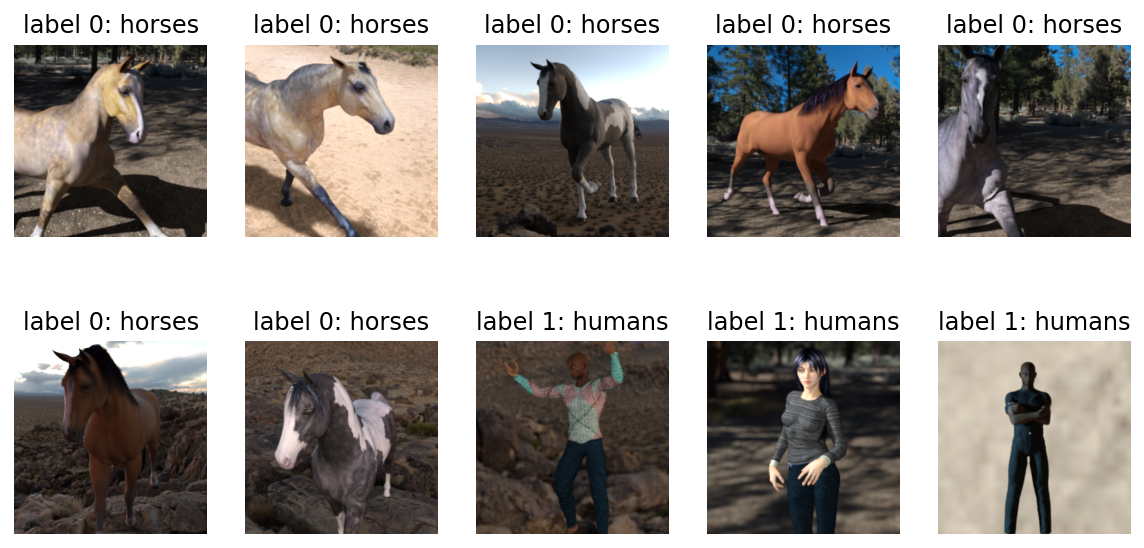

In [7]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### Image size 변경

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

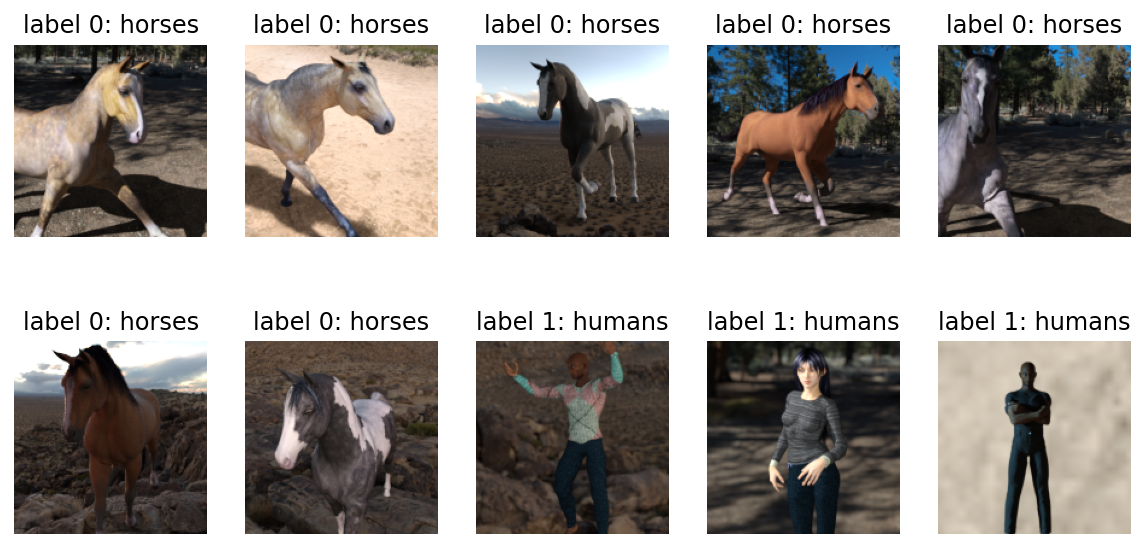

In [10]:
# 확인
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [11]:
# shape 확인
print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


### Model

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
base_model.summary()

In [13]:
# 배치 설정
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

feature_batch = base_model(image_batch)
print(feature_batch.shape)

(20, 5, 5, 512)


In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(20, 512)
(20, 1)


In [16]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
42/42 [==============================] - 4s 98ms/step - loss: 0.6588 - accuracy: 0.6740 - val_loss: 0.6390 - val_accuracy: 0.7171
Epoch 2/10
42/42 [==============================] - 3s 69ms/step - loss: 0.6384 - accuracy: 0.7470 - val_loss: 0.6240 - val_accuracy: 0.7659
Epoch 3/10
42/42 [==============================] - 3s 69ms/step - loss: 0.6184 - accuracy: 0.8139 - val_loss: 0.6057 - val_accuracy: 0.8049
Epoch 4/10
42/42 [==============================] - 3s 70ms/step - loss: 0.6000 - accuracy: 0.8564 - val_loss: 0.5885 - val_accuracy: 0.8537
Epoch 5/10
42/42 [==============================] - 3s 70ms/step - loss: 0.5818 - accuracy: 0.8905 - val_loss: 0.5745 - val_accuracy: 0.8634
Epoch 6/10
42/42 [==============================] - 3s 70ms/step - loss: 0.5642 - accuracy: 0.9100 - val_loss: 0.5586 - val_accuracy: 0.8780
Epoch 7/10
42/42 [==============================] - 3s 70ms/step - loss: 0.5480 - accuracy: 0.9258 - val_loss: 0.5428 - val_accuracy: 0.8927
Epoch 8/10
42

In [20]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/20 [==============>...............] - ETA: 0s - loss: 0.4985 - accuracy: 0.9150WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


11/20 [===============>..............] - 1s 47ms/step - loss: 0.4987 - accuracy: 0.9171
initial loss: 0.50
initial accuracy: 0.92


### 학습 확인(1) - loss 확인

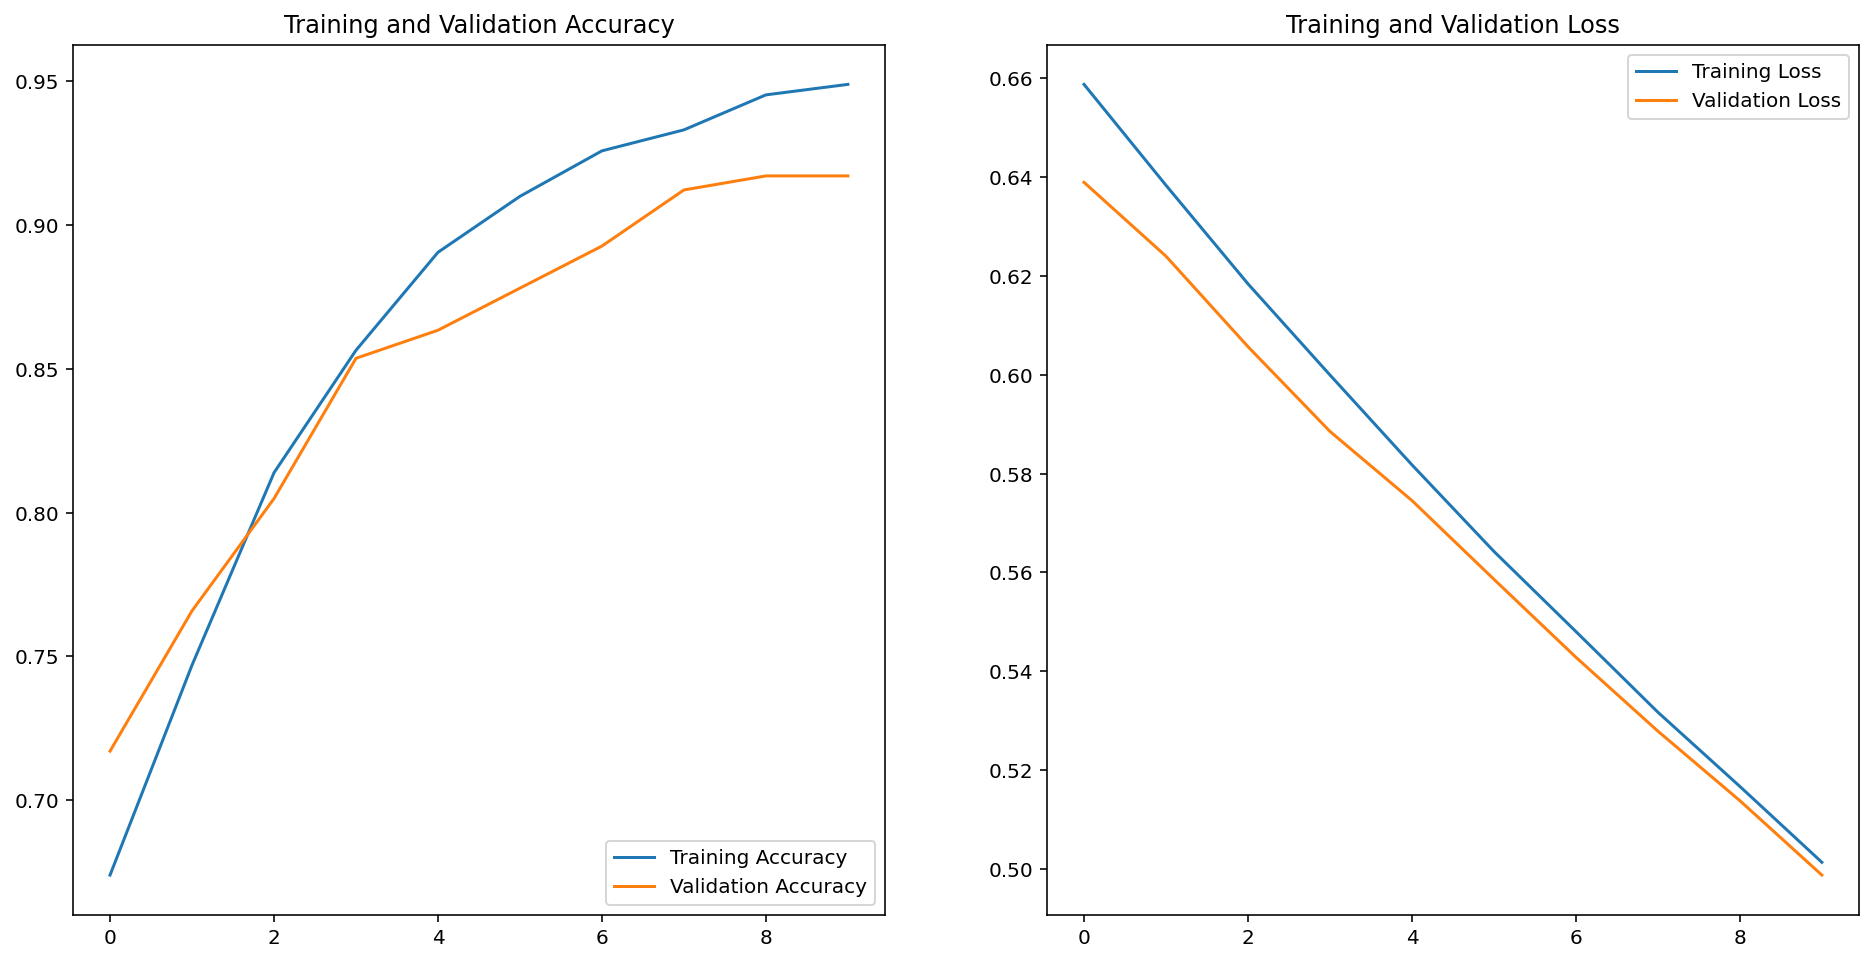

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 학습 확인(2)

In [22]:
import os
if not os.path.exists('./my_image'):
    os.mkdir('./my_image')

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# pillow 설치되었는지 확인할 것

In [41]:
IMG_SIZE = 160
filename = '/home/hyojeong-jeon/my_image/human_01.jpeg' # 절대경로로
# 주피터를 켰던 위치에서 하위폴더가 형성됨. 확인바람.

horse_vs_human = load_img(filename, target_size=(IMG_SIZE, IMG_SIZE))
horse_vs_human = img_to_array(horse_vs_human).reshape(1, IMG_SIZE, IMG_SIZE, 3)

In [42]:
prediction = model.predict(horse_vs_human)
predictions = prediction.round().astype(int)
if predictions == 0:
    print('horse')
else:
    print('human')

human
